# Text-to-Motion Retrieval — v18.1 (anti-overfit)

### Pourquoi la val se bloquait vers ~4.3
1. Validation bruitée : une description tirée au hasard par motion a chaque epoch.
2. Seulement ~9 steps/epoch : 1 seule description random par motion en train.
3. Encoder motion trop capacitaire dans les derniers essais -> gap train/val qui s'ouvre.

### Changements appliqués
1. Train en paires plates (3 descriptions par motion) -> ~3x plus de signal/epoch.
2. Val deterministe : moyenne des 3 embeddings texte par motion (plus stable).
3. Motion encoder BiLSTM + attention pooling (plus robuste) + dropout 0.20.
4. Temperature InfoNCE apprenante + early stopping plus strict.

**CLIP reste pre-extrait** pour garder un grand batch sans OOM.


## 0. Imports

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
from pathlib import Path
import random, math
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
from sklearn.model_selection import train_test_split
from transformers import CLIPTextModel, CLIPTokenizer
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device : {device}')


Device : cuda


## 1. Constantes

In [49]:
DATA_DIR   = Path('data/data')
MOTION_DIR = DATA_DIR / 'motions'
TEXT_DIR   = DATA_DIR / 'texts'
TEST_DIR   = DATA_DIR / 'test'

MAX_SEQ_LEN   = 150
BATCH_SIZE    = 512
EMBED_DIM     = 256
LSTM_HIDDEN   = 256
LSTM_BIDIR    = True
DROPOUT       = 0.25
TEMPERATURE   = 0.07
NUM_EPOCHS    = 80
WARMUP        = 5
PATIENCE      = 10
K_VALUES      = tuple(range(1, 11))
LABEL_SMOOTH  = 0.05
VAL_N_TRIALS  = 8
VAL_EVAL_SEED = 1337


## 2. Exploration

In [50]:
motion_files = sorted(MOTION_DIR.glob('*.npy'))
sample_m     = np.load(motion_files[0])
print(f'Motions train : {len(motion_files)},  shape ex : {sample_m.shape}')

test_subdirs = sorted([d for d in TEST_DIR.iterdir() if d.is_dir()], key=lambda d: int(d.name))
print(f'Test : {len(test_subdirs)} requêtes, {len(sorted(test_subdirs[0].glob("*.npy")))} candidats/requête')


Motions train : 6018,  shape ex : (94, 384)
Test : 30 requêtes, 32 candidats/requête


## 3. Parsing

In [51]:
def parse_train_texts(text_dir):
    txt_files    = sorted(Path(text_dir).glob('*.txt'))
    motion_texts = defaultdict(list)
    for tf in txt_files:
        lines = [l.strip() for l in tf.read_text('utf-8').splitlines() if l.strip()]
        parts = tf.stem.rsplit('_', 1)
        if len(parts) == 2 and parts[1].isdigit():
            motion_texts[parts[0]].append(lines[0] if lines else '')
        else:
            motion_texts[tf.stem] = lines
    n = [len(v) for v in motion_texts.values()]
    print(f'Motions : {len(motion_texts)}, descriptions : min={min(n)}, max={max(n)}, moy={sum(n)/len(n):.1f}')
    return dict(motion_texts)

motion_texts = parse_train_texts(TEXT_DIR)


Motions : 6018, descriptions : min=3, max=3, moy=3.0


## 4. Split

In [52]:
available_ids = [mf.stem for mf in sorted(MOTION_DIR.glob('*.npy')) if mf.stem in motion_texts]
train_ids, val_ids = train_test_split(available_ids, test_size=0.20, random_state=SEED, shuffle=True)
print(f'Train : {len(train_ids)} motions  |  Val : {len(val_ids)} motions')


Train : 4814 motions  |  Val : 1204 motions


## 5. Dataset

### Changement clé : 1 description aléatoire par motion par epoch

En v3 : 3 paires fixes → à chaque epoch le modèle voit exactement les mêmes textes.  
En v17 : on stocke les 3 descriptions et on en tire **une au hasard** dans `__getitem__`.  
→ Le texte change à chaque epoch → impossible à mémoriser → overfitting supprimé côté texte.

### Augmentation motion
- Bruit gaussien léger (σ=0.01) sur les features
- Temporal masking : on masque aléatoirement des blocs de frames  
  (même principe que SpecAugment en audio)


In [53]:
# ════════════════════════════════════════════════════════════════════════════════
# CLIP PRÉ-EXTRAIT — la clé pour le batch 512
# CLIP tourne une seule fois sur tous les textes train+val, les embeddings
# sont stockés en RAM. À chaque epoch, le Dataset retourne directement
# l'embedding pré-calculé → pas de forward CLIP dans la boucle d'entraînement
# → VRAM quasi-vide → batch 512 sans OOM.
# ════════════════════════════════════════════════════════════════════════════════

print('Chargement CLIP pour pré-extraction...')
_clip_model     = CLIPTextModel.from_pretrained('openai/clip-vit-base-patch32').to(device)
_clip_tokenizer = CLIPTokenizer.from_pretrained('openai/clip-vit-base-patch32')
_clip_model.eval()
for p in _clip_model.parameters():
    p.requires_grad = False

@torch.no_grad()
def _extract_clip(texts, bs=256):
    out = []
    for i in range(0, len(texts), bs):
        tok = _clip_tokenizer(texts[i:i+bs], padding=True, truncation=True,
                              max_length=77, return_tensors='pt').to(device)
        out.append(_clip_model(**tok).pooler_output.cpu())
    return torch.cat(out)   # (N, 512)

def preprocess_motion(motion, max_len):
    if motion.ndim == 3:
        motion = motion.reshape(motion.shape[0], -1)
    T, F = motion.shape
    if T > max_len:   motion = motion[:max_len]
    elif T < max_len: motion = np.concatenate([motion, np.zeros((max_len-T, F), np.float32)])
    return motion.astype(np.float32)

def augment_motion(motion, max_len):
    if motion.ndim == 3:
        motion = motion.reshape(motion.shape[0], -1)
    T_orig, F = motion.shape
    # Speed perturbation (nouveau)
    if random.random() > 0.3:
        real_T = next((i+1 for i in range(T_orig-1,-1,-1) if motion[i].any()), T_orig)
        if real_T >= 4:
            speed  = random.uniform(0.8, 1.2)
            new_T  = max(4, int(real_T / speed))
            old_t  = np.linspace(0, real_T-1, real_T)
            new_t  = np.linspace(0, real_T-1, new_T)
            motion = np.stack([np.interp(new_t, old_t, motion[:real_T, f])
                               for f in range(F)], axis=1).astype(np.float32)
    # Bruit gaussien
    motion = motion + np.random.randn(*motion.shape).astype(np.float32) * 0.01
    # Temporal masking
    if motion.shape[0] >= 10 and random.random() > 0.3:
        blk = max(1, int(motion.shape[0] * 0.10))
        s   = random.randint(0, motion.shape[0] - blk)
        motion[s:s+blk] = 0.0
    # Pad/tronque
    T, F = motion.shape
    if T > max_len:   motion = motion[:max_len]
    elif T < max_len: motion = np.concatenate([motion, np.zeros((max_len-T, F), np.float32)])
    return motion.astype(np.float32)


# ── Construire les samples et pré-extraire tous les embeddings CLIP ────────────
def build_flat_pairs(motion_ids, motion_texts, motion_dir):
    """
    Train : liste plate de (path, clip_emb_index, mid).
    Chaque motion génère 3 entrées (une par description).
    -> 3x plus de signal de gradient / epoch qu'avec 1 desc random.
    """
    pairs, all_descs = [], []
    for mid in motion_ids:
        path  = Path(motion_dir) / f'{mid}.npy'
        descs = motion_texts.get(mid, [])
        if path.exists() and descs:
            for desc in descs:
                pairs.append((path, len(all_descs), mid))
                all_descs.append(desc)
    return pairs, all_descs

def build_samples(motion_ids, motion_texts, motion_dir):
    """Val : 1 entrée par motion avec ses indices de descriptions."""
    samples, all_descs = [], []
    for mid in motion_ids:
        path  = Path(motion_dir) / f'{mid}.npy'
        descs = motion_texts.get(mid, [])
        if path.exists() and descs:
            start = len(all_descs)
            all_descs.extend(descs)
            samples.append((path, list(range(start, start+len(descs))), mid))
    return samples, all_descs

train_pairs, train_descs = build_flat_pairs(train_ids, motion_texts, MOTION_DIR)
val_samples, val_descs   = build_samples(val_ids,   motion_texts, MOTION_DIR)

print(f'Extraction CLIP train ({len(train_descs)} textes)...', end=' ', flush=True)
train_clip_embs = _extract_clip(train_descs)
print(train_clip_embs.shape)

print(f'Extraction CLIP val   ({len(val_descs)} textes)...', end=' ', flush=True)
val_clip_embs = _extract_clip(val_descs)
print(val_clip_embs.shape)

del _clip_model
torch.cuda.empty_cache()
print('CLIP libéré de la VRAM — embeddings conservés en RAM.')

MOTION_DIM = int(np.load(train_pairs[0][0]).reshape(
    np.load(train_pairs[0][0]).shape[0], -1).shape[1])
print(f'Motion dim : {MOTION_DIM}')


class FlatPairDataset(Dataset):
    """
    1 sample = 1 paire (texte, motion).
    La même motion apparaît 3 fois/epoch avec 3 textes différents
    (+ augmentations différentes), ce qui réduit le sur-apprentissage
    observé avec 1 description random.
    """
    def __init__(self, pairs, clip_embs, max_seq_len=150, augment=False):
        self.pairs       = pairs     # [(path, emb_idx, mid)]
        self.clip_embs   = clip_embs # tensor (N_descs_total, 512)
        self.max_seq_len = max_seq_len
        self.augment     = augment

    def __len__(self): return len(self.pairs)

    def __getitem__(self, idx):
        path, emb_idx, mid = self.pairs[idx]
        clip_emb = self.clip_embs[emb_idx]
        motion   = np.load(path)
        motion   = augment_motion(motion, self.max_seq_len) if self.augment                    else preprocess_motion(motion, self.max_seq_len)
        return {'clip_emb': clip_emb,
                'motion':   torch.from_numpy(motion),
                'motion_id': mid}

def collate_fn(batch):
    return {'clip_emb':  torch.stack([b['clip_emb']  for b in batch]),
            'motion':    torch.stack([b['motion']     for b in batch]),
            'motion_id': [b['motion_id'] for b in batch]}

train_dataset = FlatPairDataset(train_pairs, train_clip_embs, MAX_SEQ_LEN, augment=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=4, pin_memory=True, collate_fn=collate_fn, drop_last=True)

# TestDataset reste identique (pas de CLIP pré-extrait, rechargé à l'inférence)
n_unique_motions_train = len(set(p[2] for p in train_pairs))
print(f'Train : {len(train_dataset)} paires ({n_unique_motions_train} motions x 3 desc)')
print(f'        {len(train_loader)} batches de {BATCH_SIZE}')
print(f'Val   : {len(val_samples)} motions')


Chargement CLIP pour pré-extraction...


Loading weights: 100%|██████████| 196/196 [00:00<00:00, 1041.52it/s, Materializing param=text_model.final_layer_norm.weight]                    
CLIPTextModel LOAD REPORT from: openai/clip-vit-base-patch32
Key                                                            | Status     |  | 
---------------------------------------------------------------+------------+--+-
vision_model.encoder.layers.{0...11}.self_attn.out_proj.weight | UNEXPECTED |  | 
vision_model.encoder.layers.{0...11}.self_attn.v_proj.weight   | UNEXPECTED |  | 
vision_model.encoder.layers.{0...11}.self_attn.k_proj.bias     | UNEXPECTED |  | 
vision_model.encoder.layers.{0...11}.layer_norm1.weight        | UNEXPECTED |  | 
vision_model.encoder.layers.{0...11}.mlp.fc1.weight            | UNEXPECTED |  | 
vision_model.encoder.layers.{0...11}.self_attn.q_proj.bias     | UNEXPECTED |  | 
vision_model.encoder.layers.{0...11}.self_attn.q_proj.weight   | UNEXPECTED |  | 
vision_model.encoder.layers.{0...11}.layer_norm1.bias   

Extraction CLIP train (14442 textes)... torch.Size([14442, 512])
Extraction CLIP val   (3612 textes)... torch.Size([3612, 512])
CLIP libéré de la VRAM — embeddings conservés en RAM.
Motion dim : 384
Train : 14442 paires (4814 motions x 3 desc)
        28 batches de 512
Val   : 1204 motions


## 6. Modèle LSTM + CLIP

Architecture choisie pour limiter l'overfit tout en gardant du pouvoir de discrimination:
1. CLIP texte pré-extrait et gelé.
2. Projection texte plus riche (LN + MLP léger + dropout).
3. Motion encoder BiLSTM + attention pooling temporelle.
4. InfoNCE avec température apprenante.


In [54]:
class TextProjection(nn.Module):
    """Projection texte un peu plus riche, avec dropout léger anti-overfit."""
    def __init__(self, clip_dim=512, embed_dim=EMBED_DIM):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(clip_dim),
            nn.Linear(clip_dim, clip_dim),
            nn.GELU(),
            nn.Dropout(DROPOUT),
            nn.Linear(clip_dim, embed_dim),
        )
    def forward(self, x):
        return F.normalize(self.net(x), dim=-1)


class TemporalAttentionPooling(nn.Module):
    """Attention par frame pour éviter de dépendre seulement du dernier hidden state."""
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim, 1)

    def forward(self, out, padding_mask):
        scores  = self.attn(out).squeeze(-1)
        scores  = scores.masked_fill(padding_mask, -1e9)
        weights = F.softmax(scores, dim=1)
        return (out * weights.unsqueeze(-1)).sum(1)


class MotionEncoder(nn.Module):
    """BiLSTM + attention pooling : plus robuste que le dernier hidden seul."""
    def __init__(self, input_dim=MOTION_DIM, hidden_dim=LSTM_HIDDEN,
                 embed_dim=EMBED_DIM, dropout=DROPOUT):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=1,
                            batch_first=True, bidirectional=LSTM_BIDIR, dropout=0.0)
        out_dim = hidden_dim * (2 if LSTM_BIDIR else 1)
        self.attn_pool = TemporalAttentionPooling(out_dim)
        self.drop = nn.Dropout(dropout)
        self.proj = nn.Sequential(
            nn.LayerNorm(out_dim),
            nn.Linear(out_dim, embed_dim * 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim * 2, embed_dim),
        )

    def forward(self, x):
        padding_mask = (x.abs().sum(-1) == 0)
        out, _ = self.lstm(x)
        pooled = self.attn_pool(out, padding_mask)
        return F.normalize(self.proj(self.drop(pooled)), dim=-1)


class InfoNCELoss(nn.Module):
    """InfoNCE avec température apprenante + label smoothing anti-overfit."""
    def __init__(self, temperature=TEMPERATURE, label_smooth=LABEL_SMOOTH):
        super().__init__()
        self.log_temp = nn.Parameter(torch.tensor(math.log(1.0 / temperature)))
        self.label_smooth = label_smooth

    @property
    def temperature(self):
        return (1.0 / self.log_temp.exp().clamp(max=25.0)).item()

    def forward(self, t, m):
        N      = len(t)
        labels = torch.arange(N, device=t.device)
        scale  = self.log_temp.exp().clamp(max=25.0)
        logits = (t @ m.T) * scale
        return (F.cross_entropy(logits, labels, label_smoothing=self.label_smooth) +
                F.cross_entropy(logits.T, labels, label_smoothing=self.label_smooth)) / 2


class TextMotionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.text_proj  = TextProjection()
        self.motion_enc = MotionEncoder()
        self.loss_fn    = InfoNCELoss()

    def forward(self, clip_embs, motions):
        t = self.text_proj(clip_embs)
        m = self.motion_enc(motions)
        return self.loss_fn(t, m), t, m

    def encode_clip(self, clip_embs): return self.text_proj(clip_embs)
    def encode_motion(self, motions): return self.motion_enc(motions)


model = TextMotionModel().to(device)

total     = sum(p.numel() for p in model.parameters())
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Paramètres totaux      : {total:,}')
print(f'Paramètres entraîn.    : {trainable:,}')
print(f'  TextProjection       : {sum(p.numel() for p in model.text_proj.parameters()):,}')
print(f'  MotionEncoder        : {sum(p.numel() for p in model.motion_enc.parameters()):,}')
print(f'  Température (init)   : T={model.loss_fn.temperature:.4f} (apprenante)')


Paramètres totaux      : 2,105,346
Paramètres entraîn.    : 2,105,346
  TextProjection       : 395,008
  MotionEncoder        : 1,710,337
  Température (init)   : T=0.0700 (apprenante)


## 7. Métriques

In [55]:
def kaggle_score(recalls):
    ks = sorted(recalls.keys())
    return sum(recalls[k] / k for k in ks) / sum(1.0 / k for k in ks)


@torch.no_grad()
def compute_val_metrics(model, val_samples, val_clip_embs_all, device,
                        k_values=K_VALUES, n_distractors=31, n_trials=5):
    """
    Val déterministe :
    - texte = moyenne des 3 embeddings CLIP de la motion
    - motion = embedding sans augmentation
    Cela retire le bruit du random sampling en validation.
    """
    model.eval()
    all_t, all_m, all_mids = [], [], []

    for path, desc_indices, mid in val_samples:
        mean_emb = val_clip_embs_all[desc_indices].mean(0, keepdim=True)
        t = model.encode_clip(mean_emb.to(device)).cpu()
        motion = preprocess_motion(np.load(path), MAX_SEQ_LEN)
        m = model.encode_motion(
            torch.from_numpy(motion).unsqueeze(0).to(device)).cpu()
        all_t.append(t); all_m.append(m); all_mids.append(mid)

    T = torch.cat(all_t)
    M = torch.cat(all_m)
    N = len(T)

    scale = model.loss_fn.log_temp.exp().clamp(max=100.0).item()
    logits = (T.to(device) @ M.to(device).T) * scale
    labels = torch.arange(N, device=device)
    avg_val_loss = ((F.cross_entropy(logits, labels) +
                    F.cross_entropy(logits.T, labels)) / 2).item()

    mid_to_idx = defaultdict(list)
    for idx, mid in enumerate(all_mids):
        mid_to_idx[mid].append(idx)

    recalls = {k: 0.0 for k in k_values}
    for _ in range(n_trials):
        for i in range(N):
            correct_idxs = set(mid_to_idx[all_mids[i]])
            distractors  = [j for j in range(N) if j not in correct_idxs]
            pool         = list(correct_idxs) + random.sample(
                               distractors, min(n_distractors, len(distractors)))
            sims   = (T[i].unsqueeze(0) @ M[pool].T).squeeze(0)
            ranked = torch.argsort(sims, descending=True).tolist()
            correct_pool = set(range(len(correct_idxs)))
            for k in k_values:
                if any(r in correct_pool for r in ranked[:k]):
                    recalls[k] += 1.0

    recalls = {k: v / (N * n_trials) for k, v in recalls.items()}
    return avg_val_loss, recalls, kaggle_score(recalls)

print('Métriques OK.')


Métriques OK.


## 8. Entraînement — warmup + cosine + early stopping

In [56]:
optimizer = torch.optim.AdamW([
    {'params': model.text_proj.parameters(),  'lr': 3e-4,  'weight_decay': 0.05},
    {'params': model.motion_enc.parameters(), 'lr': 2.5e-4,'weight_decay': 0.12},
    {'params': [model.loss_fn.log_temp],      'lr': 5e-4,  'weight_decay': 0.0},
])

def lr_lambda(epoch):
    if epoch < WARMUP:
        return (epoch + 1) / WARMUP
    progress = (epoch - WARMUP) / max(1, NUM_EPOCHS - WARMUP)
    return 0.5 * (1.0 + math.cos(math.pi * progress))

scheduler  = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
best_score = 0.0
no_improve = 0
history    = []

for epoch in range(1, NUM_EPOCHS + 1):

    # ── Train ─────────────────────────────────────────────────────────────────
    model.train()
    total_loss = 0.0
    pbar = tqdm(train_loader, desc=f'Epoch {epoch:3d}/{NUM_EPOCHS}', leave=False)
    for batch in pbar:
        optimizer.zero_grad(set_to_none=True)
        loss, _, _ = model(batch['clip_emb'].to(device), batch['motion'].to(device))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.7)
        optimizer.step()
        total_loss += loss.item()
        pbar.set_postfix(loss=f'{loss.item():.4f}')
    avg_loss = total_loss / len(train_loader)
    scheduler.step()

    # ── Val ───────────────────────────────────────────────────────────────────
    avg_val, val_r, score = compute_val_metrics(
        model, val_samples, val_clip_embs, device)
    r1, r5, r10 = val_r[1], val_r[5], val_r[10]
    lr_cur = optimizer.param_groups[1]['lr']
    temp_cur = model.loss_fn.temperature

    print(f'Epoch {epoch:3d} | train {avg_loss:.4f}  val {avg_val:.4f} | '
          f'R@1 {r1:.4f}  R@5 {r5:.4f}  R@10 {r10:.4f} | '
          f'Score {score:.4f} | T={temp_cur:.4f} | lr {lr_cur:.2e}')

    history.append({'epoch': epoch, 'train_loss': avg_loss, 'val_loss': avg_val,
                    'R@1': r1, 'R@5': r5, 'R@10': r10, 'score': score,
                    'temperature': temp_cur})

    if score > best_score:
        best_score = score
        no_improve = 0
        torch.save(model.state_dict(), 'best_model_v18.pt')
        print(f'  -> Meilleur score sauvegardé (Score={score:.4f})')
    else:
        no_improve += 1
        if no_improve >= PATIENCE:
            print(f'  -> Early stopping ({PATIENCE} epochs sans amélioration)')
            break

    if epoch % 20 == 0:
        torch.save(model.state_dict(), f'checkpoint_v18_epoch_{epoch}.pt')

print(f'\nMeilleur Score Kaggle val : {best_score:.4f}')


Epoch   1 | train 6.2510  val 6.8851 | R@1 0.1045  R@5 0.3573  R@10 0.5806 | Score 0.2509 | T=0.0702 | lr 1.00e-04
  -> Meilleur score sauvegardé (Score=0.2509)


Epoch   2 | train 5.9600  val 6.4070 | R@1 0.1922  R@5 0.5346  R@10 0.7359 | Score 0.3873 | T=0.0703 | lr 1.50e-04
  -> Meilleur score sauvegardé (Score=0.3873)


Epoch   3 | train 5.5959  val 6.0068 | R@1 0.2633  R@5 0.6507  R@10 0.8362 | Score 0.4815 | T=0.0705 | lr 2.00e-04
  -> Meilleur score sauvegardé (Score=0.4815)


Epoch   4 | train 5.2827  val 5.6997 | R@1 0.3211  R@5 0.7410  R@10 0.9010 | Score 0.5574 | T=0.0706 | lr 2.50e-04
  -> Meilleur score sauvegardé (Score=0.5574)


Epoch   5 | train 5.0384  val 5.4960 | R@1 0.3646  R@5 0.8045  R@10 0.9309 | Score 0.6112 | T=0.0706 | lr 2.50e-04
  -> Meilleur score sauvegardé (Score=0.6112)


Epoch   6 | train 4.8231  val 5.3533 | R@1 0.3975  R@5 0.8312  R@10 0.9392 | Score 0.6386 | T=0.0704 | lr 2.50e-04
  -> Meilleur score sauvegardé (Score=0.6386)


Epoch   7 | train 4.6508  val 5.2506 | R@1 0.4274  R@5 0.8362  R@10 0.9440 | Score 0.6568 | T=0.0700 | lr 2.50e-04
  -> Meilleur score sauvegardé (Score=0.6568)


Epoch   8 | train 4.4843  val 5.1757 | R@1 0.4412  R@5 0.8543  R@10 0.9537 | Score 0.6732 | T=0.0693 | lr 2.49e-04
  -> Meilleur score sauvegardé (Score=0.6732)


Epoch   9 | train 4.3489  val 5.0833 | R@1 0.4650  R@5 0.8673  R@10 0.9517 | Score 0.6932 | T=0.0686 | lr 2.48e-04
  -> Meilleur score sauvegardé (Score=0.6932)


Epoch  10 | train 4.2253  val 5.1345 | R@1 0.4703  R@5 0.8571  R@10 0.9523 | Score 0.6877 | T=0.0678 | lr 2.47e-04


Epoch  11 | train 4.1054  val 5.0556 | R@1 0.4786  R@5 0.8698  R@10 0.9550 | Score 0.6997 | T=0.0669 | lr 2.46e-04
  -> Meilleur score sauvegardé (Score=0.6997)


Epoch  12 | train 3.9896  val 5.0214 | R@1 0.4914  R@5 0.8713  R@10 0.9543 | Score 0.7054 | T=0.0660 | lr 2.45e-04
  -> Meilleur score sauvegardé (Score=0.7054)


Epoch  13 | train 3.8877  val 5.0043 | R@1 0.4970  R@5 0.8673  R@10 0.9580 | Score 0.7062 | T=0.0650 | lr 2.43e-04
  -> Meilleur score sauvegardé (Score=0.7062)


Epoch  14 | train 3.7601  val 4.9882 | R@1 0.5063  R@5 0.8724  R@10 0.9581 | Score 0.7145 | T=0.0639 | lr 2.41e-04
  -> Meilleur score sauvegardé (Score=0.7145)


Epoch  15 | train 3.6601  val 4.9490 | R@1 0.5053  R@5 0.8786  R@10 0.9568 | Score 0.7167 | T=0.0630 | lr 2.39e-04
  -> Meilleur score sauvegardé (Score=0.7167)


Epoch  16 | train 3.5622  val 4.9469 | R@1 0.5103  R@5 0.8771  R@10 0.9561 | Score 0.7177 | T=0.0620 | lr 2.37e-04
  -> Meilleur score sauvegardé (Score=0.7177)


Epoch  17 | train 3.4558  val 4.9462 | R@1 0.5271  R@5 0.8693  R@10 0.9573 | Score 0.7235 | T=0.0610 | lr 2.35e-04
  -> Meilleur score sauvegardé (Score=0.7235)


Epoch  18 | train 3.3601  val 5.0008 | R@1 0.5108  R@5 0.8703  R@10 0.9596 | Score 0.7176 | T=0.0600 | lr 2.32e-04


Epoch  19 | train 3.2620  val 4.9613 | R@1 0.5272  R@5 0.8769  R@10 0.9565 | Score 0.7251 | T=0.0591 | lr 2.29e-04
  -> Meilleur score sauvegardé (Score=0.7251)


Epoch  20 | train 3.1690  val 4.9711 | R@1 0.5257  R@5 0.8762  R@10 0.9520 | Score 0.7253 | T=0.0581 | lr 2.26e-04
  -> Meilleur score sauvegardé (Score=0.7253)


Epoch  21 | train 3.0762  val 4.9840 | R@1 0.5279  R@5 0.8767  R@10 0.9558 | Score 0.7255 | T=0.0572 | lr 2.23e-04
  -> Meilleur score sauvegardé (Score=0.7255)


Epoch  22 | train 2.9838  val 5.0115 | R@1 0.5281  R@5 0.8741  R@10 0.9518 | Score 0.7245 | T=0.0563 | lr 2.20e-04


Epoch  23 | train 2.9224  val 4.9847 | R@1 0.5311  R@5 0.8749  R@10 0.9571 | Score 0.7278 | T=0.0555 | lr 2.16e-04
  -> Meilleur score sauvegardé (Score=0.7278)


Epoch  24 | train 2.8198  val 5.0503 | R@1 0.5199  R@5 0.8786  R@10 0.9593 | Score 0.7221 | T=0.0548 | lr 2.12e-04


Epoch  25 | train 2.7555  val 5.0625 | R@1 0.5289  R@5 0.8761  R@10 0.9591 | Score 0.7272 | T=0.0541 | lr 2.09e-04


Epoch  26 | train 2.6726  val 5.0749 | R@1 0.5256  R@5 0.8704  R@10 0.9538 | Score 0.7219 | T=0.0533 | lr 2.05e-04


Epoch  27 | train 2.6201  val 5.1262 | R@1 0.5246  R@5 0.8726  R@10 0.9528 | Score 0.7215 | T=0.0526 | lr 2.01e-04


Epoch  28 | train 2.5481  val 5.1255 | R@1 0.5214  R@5 0.8638  R@10 0.9513 | Score 0.7179 | T=0.0520 | lr 1.96e-04


Epoch  29 | train 2.4756  val 5.1156 | R@1 0.5214  R@5 0.8668  R@10 0.9488 | Score 0.7184 | T=0.0514 | lr 1.92e-04


Epoch  30 | train 2.4114  val 5.1475 | R@1 0.5259  R@5 0.8668  R@10 0.9457 | Score 0.7208 | T=0.0508 | lr 1.88e-04


Epoch  31 | train 2.3604  val 5.1864 | R@1 0.5256  R@5 0.8653  R@10 0.9502 | Score 0.7185 | T=0.0502 | lr 1.83e-04


Epoch  32 | train 2.2919  val 5.1883 | R@1 0.5216  R@5 0.8683  R@10 0.9477 | Score 0.7183 | T=0.0496 | lr 1.78e-04


Epoch  33 | train 2.2419  val 5.2486 | R@1 0.5284  R@5 0.8600  R@10 0.9449 | Score 0.7177 | T=0.0491 | lr 1.73e-04
  -> Early stopping (10 epochs sans amélioration)

Meilleur Score Kaggle val : 0.7278


## 9. Courbes

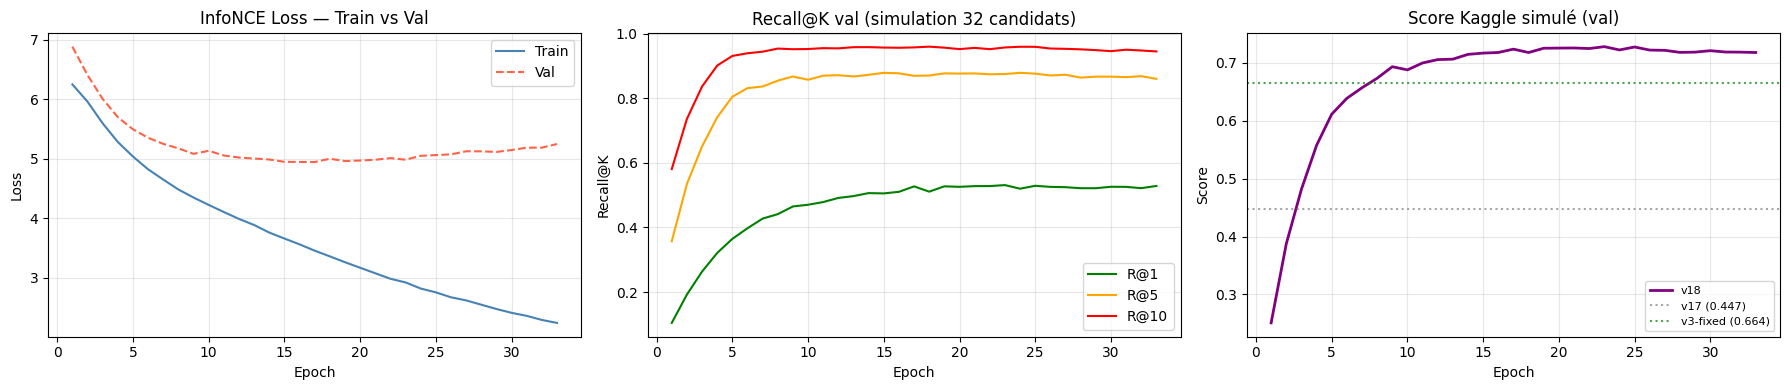

Meilleure époque : 23
  R@1=0.5311  R@5=0.8749  R@10=0.9571
  Score Kaggle simulé : 0.7278
  Gap val-train : +2.0623  (overfitting)


In [57]:
hist_df = pd.DataFrame(history)
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

axes[0].plot(hist_df['epoch'], hist_df['train_loss'], label='Train', color='steelblue')
axes[0].plot(hist_df['epoch'], hist_df['val_loss'],   label='Val',   color='tomato', linestyle='--')
axes[0].set(xlabel='Epoch', ylabel='Loss', title='InfoNCE Loss — Train vs Val')
axes[0].legend(); axes[0].grid(alpha=0.3)

for k, c in zip([1, 5, 10], ['green', 'orange', 'red']):
    axes[1].plot(hist_df['epoch'], hist_df[f'R@{k}'], label=f'R@{k}', color=c)
axes[1].set(xlabel='Epoch', ylabel='Recall@K', title='Recall@K val (simulation 32 candidats)')
axes[1].legend(); axes[1].grid(alpha=0.3)

axes[2].plot(hist_df['epoch'], hist_df['score'], color='purple', linewidth=2, label='v18')
axes[2].axhline(0.4470, color='gray',  linestyle=':', alpha=0.7, label='v17 (0.447)')
axes[2].axhline(0.6643, color='green', linestyle=':', alpha=0.7, label='v3-fixed (0.664)')
axes[2].set(xlabel='Epoch', ylabel='Score', title='Score Kaggle simulé (val)')
axes[2].legend(fontsize=8); axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves_v18.png', dpi=150)
plt.show()

best = hist_df.loc[hist_df['score'].idxmax()]
print(f"Meilleure époque : {int(best['epoch'])}")
print(f"  R@1={best['R@1']:.4f}  R@5={best['R@5']:.4f}  R@10={best['R@10']:.4f}")
print(f"  Score Kaggle simulé : {best['score']:.4f}")
gap = best['val_loss'] - best['train_loss']
print(f"  Gap val-train : {gap:+.4f}  ({'OK' if abs(gap) < 0.8 else 'overfitting' if gap > 0 else 'underfitting'})")


## 10. Submission

In [58]:
model.load_state_dict(torch.load('best_model_v18.pt', map_location=device))
model.eval()
print('Meilleur modèle v18 chargé.')

# Recharger CLIP pour l'inférence (encode les requêtes texte du test)
print('Rechargement CLIP pour inférence...')
_clip_inf   = CLIPTextModel.from_pretrained('openai/clip-vit-base-patch32').to(device)
_clip_tok   = CLIPTokenizer.from_pretrained('openai/clip-vit-base-patch32')
_clip_inf.eval()
for p in _clip_inf.parameters():
    p.requires_grad = False

@torch.no_grad()
def encode_text_query(text):
    tok = _clip_tok([text], padding=True, truncation=True,
                    max_length=77, return_tensors='pt').to(device)
    emb = _clip_inf(**tok).pooler_output
    return model.encode_clip(emb)


Meilleur modèle v18 chargé.
Rechargement CLIP pour inférence...


Loading weights: 100%|██████████| 196/196 [00:00<00:00, 984.81it/s, Materializing param=text_model.final_layer_norm.weight]                    
CLIPTextModel LOAD REPORT from: openai/clip-vit-base-patch32
Key                                                            | Status     |  | 
---------------------------------------------------------------+------------+--+-
vision_model.encoder.layers.{0...11}.self_attn.out_proj.weight | UNEXPECTED |  | 
vision_model.encoder.layers.{0...11}.self_attn.v_proj.weight   | UNEXPECTED |  | 
vision_model.encoder.layers.{0...11}.self_attn.k_proj.bias     | UNEXPECTED |  | 
vision_model.encoder.layers.{0...11}.layer_norm1.weight        | UNEXPECTED |  | 
vision_model.encoder.layers.{0...11}.mlp.fc1.weight            | UNEXPECTED |  | 
vision_model.encoder.layers.{0...11}.self_attn.q_proj.bias     | UNEXPECTED |  | 
vision_model.encoder.layers.{0...11}.self_attn.q_proj.weight   | UNEXPECTED |  | 
vision_model.encoder.layers.{0...11}.layer_norm1.bias    

In [59]:
TOP_K = 10
submission_rows = []
test_subdirs = sorted([d for d in TEST_DIR.iterdir() if d.is_dir()],
                      key=lambda d: int(d.name))

with torch.no_grad():
    for sd in tqdm(test_subdirs, desc='Generation submission'):
        query_id = int(sd.name)
        query_text = (sd / 'text.txt').read_text('utf-8').strip()

        q_emb = encode_text_query(query_text)

        candidate_files = sorted(sd.glob('*.npy'))
        candidate_ids = [f.stem for f in candidate_files]
        motions = torch.stack([
            torch.from_numpy(preprocess_motion(np.load(f), MAX_SEQ_LEN))
            for f in candidate_files
        ]).to(device)
        m_embs = model.encode_motion(motions)

        sims = (q_emb @ m_embs.T).squeeze(0)
        top_idx = torch.topk(sims, k=min(TOP_K, len(candidate_ids))).indices.cpu().tolist()

        row = {'query_id': query_id}
        for rank, ci in enumerate(top_idx, start=1):
            row[f'candidate_{rank}'] = candidate_ids[ci]
        submission_rows.append(row)

cols = ['query_id'] + [f'candidate_{k}' for k in range(1, TOP_K + 1)]
submission_df = pd.DataFrame(submission_rows).reindex(columns=cols)
submission_df = submission_df.sort_values('query_id').reset_index(drop=True)
submission_df.to_csv('submission_v18.csv', index=False)
print('\nsubmission_v18.csv generee !')
print(submission_df.head().to_string(index=False))

errors = 0
for _, row in submission_df.iterrows():
    cands = row[[f'candidate_{k}' for k in range(1, TOP_K + 1)]].dropna().tolist()
    if len(cands) != len(set(cands)):
        print(f'[!] Doublon query_id={row["query_id"]}')
        errors += 1
    if len(cands) != TOP_K:
        print(f'[!] query_id={row["query_id"]}: {len(cands)}/{TOP_K}')
        errors += 1
if len(submission_df) != len(test_subdirs):
    print(f'[!] Nombre de lignes incorrect: {len(submission_df)} (attendu {len(test_subdirs)})')
    errors += 1
if errors == 0:
    print(f'Soumission valide : {len(submission_df)} requetes, {TOP_K} candidats, 0 doublon.')


Generation submission: 100%|██████████| 30/30 [00:01<00:00, 18.61it/s]


submission_v18.csv generee !
 query_id candidate_1 candidate_2 candidate_3 candidate_4 candidate_5 candidate_6 candidate_7 candidate_8 candidate_9 candidate_10
        1   motion_17   motion_30   motion_15    motion_6    motion_8   motion_28   motion_10    motion_5   motion_23     motion_1
        2   motion_11   motion_31    motion_8   motion_18   motion_21    motion_9    motion_7   motion_22   motion_29    motion_24
        3   motion_22   motion_18   motion_30   motion_21    motion_3    motion_7   motion_28   motion_17   motion_16     motion_9
        4    motion_7   motion_31   motion_20   motion_24    motion_2   motion_27   motion_23   motion_32   motion_28     motion_1
        5   motion_28   motion_24    motion_6   motion_26   motion_18   motion_17   motion_10    motion_4   motion_21     motion_7
Soumission valide : 30 requetes, 10 candidats, 0 doublon.
